## Introduction

The goal of this project is to predict the probability of three different interest levels of apartment rental listings using machine learning methods. An apartment rental listing includes content like text description, photos, number of bedrooms, and prices, etc. It aims at attracting the most interest from potential renters. Therefore, both the apartment owners, potential renters and the website hosting the apartment rental listings are interested in figuring out how popular an apartment rental listing is. This work provides a solution for the Kaggle Two-Sigma competition. See more details about this competition here: https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

## Data
The data is from Kaggle Two-Sigma competition, which provides both training and testing data set for the apartment rental listings.

The training dataset contains 49352 entries and 15 columns including interest_level. Here interest_level is the target variable and it’s defined as the number of inquiries a listing has in the duration that the listing was live on the site. The testing dataset contains 74659 entries and 14 columns (without interest_level).

## Method
I first reframe the problem as a three-class classification problem with target as interest_level as 'low' or 'medium' or 'high'. Then I’ll start with explanatory statistical analysis of the training data set, then clean the data and try out different feature engineers, followed by feeding engineered data into various machine learning algorithms. Next, I’ll use optimized algorithms to predict the probability that each apartment listing falls into the three classes -- low, medium or high.

The following codes includes 
- Part I. Data exploration & statistical analysis
- Part II. feature engineering 
- Part III. machine learning

## Import Modules

In [490]:
%matplotlib inline
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import product
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

## Part I. Data exploration & statistical analysis


### 1. Upload data

In [491]:
train = pd.read_json('train.json')
test = pd.read_json('test.json')

### 2. Statistical analysis and visualization

#### First, let's get an overall impression of the training/testing dataset.

In [492]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [493]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 99999
Data columns (total 14 columns):
bathrooms          74659 non-null float64
bedrooms           74659 non-null int64
building_id        74659 non-null object
created            74659 non-null object
description        74659 non-null object
display_address    74659 non-null object
features           74659 non-null object
latitude           74659 non-null float64
listing_id         74659 non-null int64
longitude          74659 non-null float64
manager_id         74659 non-null object
photos             74659 non-null object
price              74659 non-null int64
street_address     74659 non-null object
dtypes: float64(3), int64(3), object(8)
memory usage: 8.5+ MB


The training dataset contains 49352 entries and 15 columns, 6 of which are numerical and the other 9 are object type. 
The testing dataset contains 74659 entries and 14 columns ( it doesn't have 'interest_level'), 6 of which are numerical and the other 8 are object type. 


Let's take a look at the data to get
an idea of how each column looks like.

In [494]:
train.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street


In [495]:
test.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
100,1.0,1,3dbbb69fd52e0d25131aa1cd459c87eb,2016-06-03 04:29:40,New York chic has reached a new level ...,101 East 10th Street,"[Doorman, Elevator, No Fee]",40.7306,7103890,-73.9890,9ca6f3baa475c37a3b3521a394d65467,[https://photos.renthop.com/2/7103890_85b33077...,3758,101 East 10th Street


In [496]:
train.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
interest_level     0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

In [497]:
test.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

Luckily, there is no missing values in both the training and testing dataset. (Handling missing values is a very important part of machine learning.)

Next, let's get some statistical idea of the numerical columns

In [498]:
train.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


In [499]:
test.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,74659.000000,74659.000000,74659.000000,7.465900e+04,74659.000000,7.465900e+04
mean,1.212915,1.544663,40.735060,7.024001e+06,-73.945282,3.749033e+03
std,0.649820,1.107014,0.806687,1.264496e+05,1.487795,9.713092e+03
min,0.000000,0.000000,0.000000,6.811958e+06,-121.488000,1.000000e+00
25%,1.000000,1.000000,40.727800,6.915516e+06,-73.991800,2.495000e+03
50%,1.000000,1.000000,40.751600,7.021738e+06,-73.977700,3.150000e+03
75%,1.000000,2.000000,40.774300,7.129166e+06,-73.954700,4.100000e+03
max,112.000000,7.000000,42.872700,7.761779e+06,0.000000,1.675000e+06


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ACA7EDE1D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001ACA7DFF080>]], dtype=object)

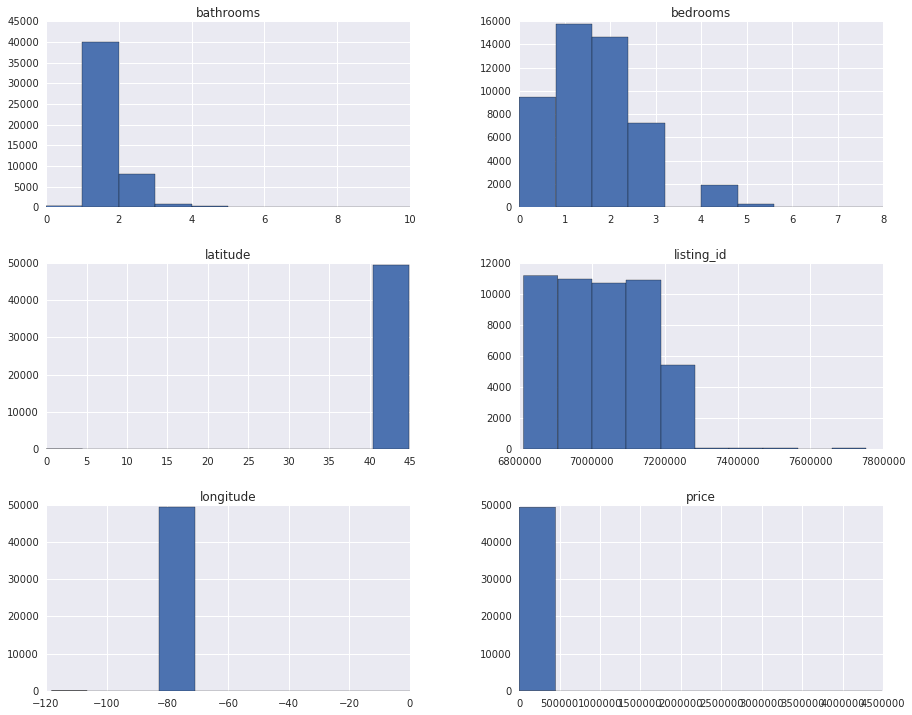

In [500]:
train.hist(figsize = (15,  12))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ACA7D3DFD0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001ACFB62D710>]], dtype=object)

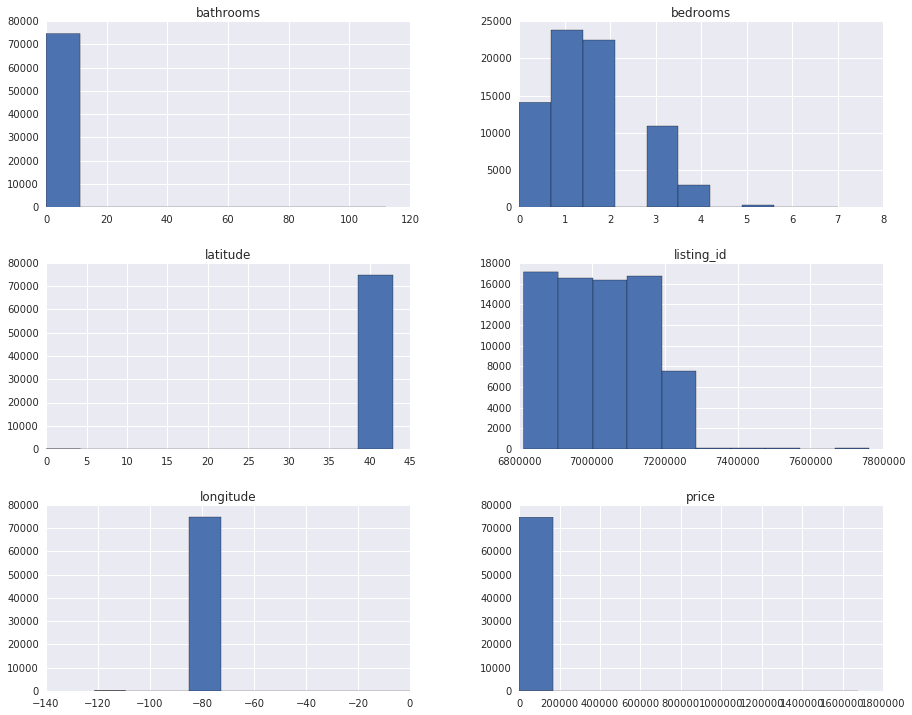

In [501]:
test.hist(figsize = (15,  12))

Some insights from the above table and graph about the training dataset are:
- 1, Minimum value of the lattitude and longitude are 0 and -118.27, which may be outliers given that this is new york city 
    apartment rental listings and the lattitude and longitude of new york city are 40.730610 and -73.935242, respectively.
- 2, All listing_id are 10^6 level. max(listing_id) - min(listing_id) = 941827, which is about 20 times of the size of the dataset(49352). One question to keep in mind is how the listing_ids are assigned?
- 3, The price ranges from 43 to 4.490000e+06. It is a much wider range than we normally see for apartment rentals. It may worth normalizing it using number of bedrooms/bathrooms/totalrooms.

Similar insights about the suspected 'outliers' in the lattitude and longitude, wide range of listing_id and price can also be drawn from the testing dataset.

#### Next, let's analyze and visualize all the features one by one to gain more insights about them.

#### 1.Interest Level

In [502]:
# get the counts of each category
train.groupby('interest_level').size()

interest_level
high       3839
low       34284
medium    11229
dtype: int64

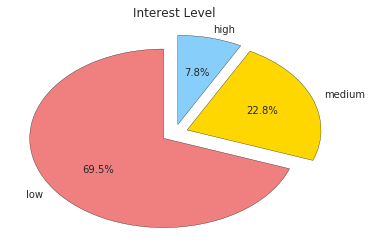

In [503]:
# plot the interest_level in a pie chart
labels = ['low', 'medium', 'high']

# sizes = array([34284, 11229,  3839], dtype=int64)
sizes = train['interest_level'].value_counts().values

# specifies the fraction of the radius with which to offset each wedge
explode = [0.1, 0.1, 0.1]

colors = ['lightcoral','gold','lightskyblue']

# autopct is a string used to label the wedges with their numeric value
patches, texts, autotexts = plt.pie(sizes, labels = labels, colors = colors, explode = explode, autopct="%1.1f%%",
                        startangle = 90)
plt.title('Interest Level')
plt.show()

There're three different interest_level: 'low', 'medium', 'high'. This is a three-class classification problems.

#### 2.manager_id

In [504]:
# find out the sorted unique values and the counts
unique, counts = np.unique(train['manager_id'], return_counts = True)
unique, counts, len(unique)

(array(['0000abd7518b94c35a90d64b56fbf3e6',
        '001ce808ce1720e24a9510e014c69707',
        '003fc4e9a70053082f131b1054966aaf', ...,
        'ffb9eceeaa4d60da7b41cc8f0954cd50',
        'ffd3c60281949a5cd806030203a79558',
        'ffd7307e4924587b30ec014a95db1362'], dtype=object),
 array([ 12,  10,   1, ...,   2,   7, 115], dtype=int64),
 3481)

In [505]:
# find out the sorted unique values and the counts
unique, counts = np.unique(test['manager_id'], return_counts = True)
unique, counts, len(unique)

(array(['0000abd7518b94c35a90d64b56fbf3e6',
        '001ce808ce1720e24a9510e014c69707',
        '003fc4e9a70053082f131b1054966aaf', ...,
        'ffd3c60281949a5cd806030203a79558',
        'ffd7307e4924587b30ec014a95db1362',
        'fffdb8b4c7b05e16f7b4ef10c2640836'], dtype=object),
 array([ 23,  18,   3, ...,   5, 163,   1], dtype=int64),
 3851)

In the training dataset, 49352 entries only has 3481 unique manager_id. Similarily, the testing dataset has 74659 entries and only 3851 unique manager_id. That means multiple listings share the same manager_id in both the training and testing dataset.

Let's figure out these high profile managers and see whether they are the same in the training and testing dataset.

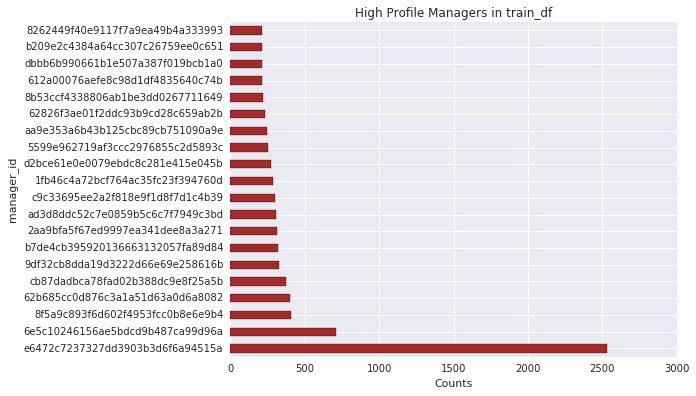

In [506]:
def highprofileid(df, column, title):
    DF = df.groupby([column])[column].count().fillna(0)
    DF.head()
    x = DF.sort_values(ascending=False)
    x = x[:20]
    plt.title(title)
    plt.xlabel("Counts")
    plt.ylabel(column)
    x.plot(kind='barh',color="brown", figsize = (8, 6))
    
highprofileid(train, 'manager_id', 'High Profile Managers in train_df')

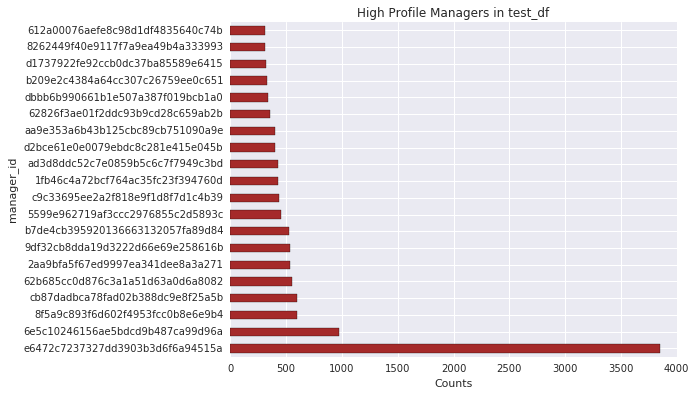

In [507]:
highprofileid(test, 'manager_id', 'High Profile Managers in test_df')

Many high profile managers in the training dataset turns out to be also high profile managers in the testing dataset. Assuming each manager has consistent working style which is very likely to be true, we can image that the ratios of postings in each of the three interest_level categories ('low', 'medium', 'high') by the same manager are close or the same in the training datset and the testing dataset.

#### 3. 'building_id'

In [508]:
unique, counts = np.unique(train['building_id'], return_counts = True)
unique, counts, len(unique)

(array(['0', '00005cb939f9986300d987652c933e15',
        '00024d77a43f0606f926e2312513845c', ...,
        'ffe55387cd931c117ee1b8446f21953b',
        'fff0a02ad82421c226c6d6765a0dde57',
        'fff5915444b98b72a44a9456901f083c'], dtype=object),
 array([8286,    1,    3, ...,    1,    1,    2], dtype=int64),
 7585)

In [509]:
unique, counts = np.unique(test['building_id'], return_counts = True)
unique, counts, len(unique)

(array(['0', '00024d77a43f0606f926e2312513845c',
        '000ae4b7db298401cdae2b0ba1ea8146', ...,
        'fff4d2a45cf0eecb1cf3ea8937f0d804',
        'fff5915444b98b72a44a9456901f083c',
        'fffdcb49cb93d2a90e5324da13932876'], dtype=object),
 array([12378,     4,     1, ...,     1,     3,     1], dtype=int64),
 9321)

In the training dataset, 49352 entries contains 7585 unique building_id. In the testing dataset, 74659 entries contains 9321 unique building_id. That means multiple listing share one building_id, as seen in counts.
Also, in both cases, the one with the highest counts is '0', which is different style as the rest building ids.
Similarly, let's figure out these high profile managers and see whether they are the same in the training and testing dataset.

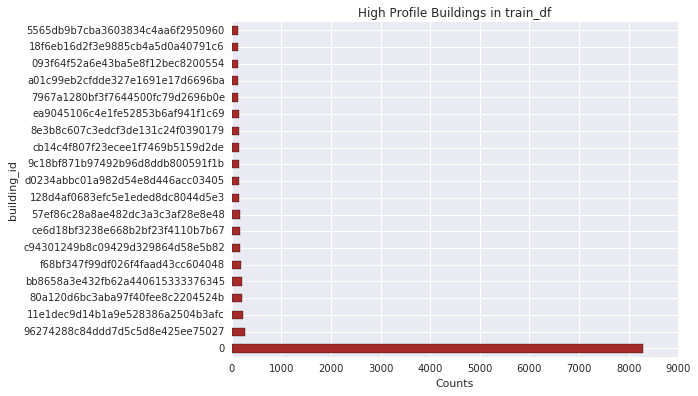

In [510]:
# removing the outlier
highprofileid(train, 'building_id', 'High Profile Buildings in train_df')

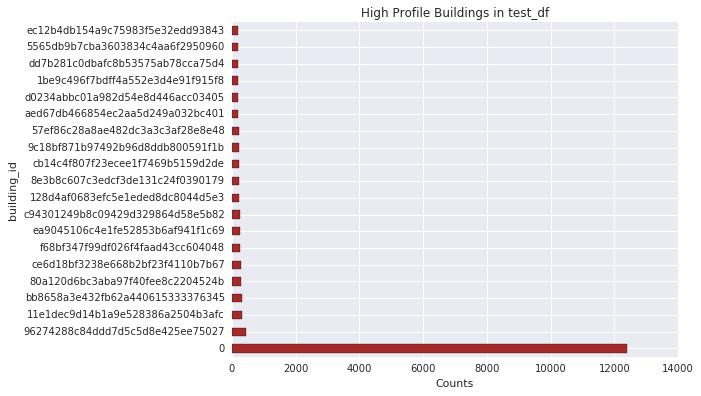

In [511]:
highprofileid(test, 'building_id', 'High Profile Buildings in test_df')

Similarily, the training and testing dataset share very similar high profile buildings. Given that apartments in the same building
share similar location, facilities and local environment, we imagine that building_id also plays a big role in determining the 
interest_level. Moreover, the ratios of postings in each of the three interest_level categories ('low', 'medium', 'high') in the same
building (or postings with the same building_id) are close or the same in the training datset and the testing dataset.

#### 4.'listing_id'

In [512]:
unique, counts = np.unique(train['listing_id'], return_counts = True)
unique, counts, len(unique)

(array([6811957, 6811965, 6811966, ..., 7742670, 7742803, 7753784], dtype=int64),
 array([1, 1, 1, ..., 1, 1, 1], dtype=int64),
 49352)

In [513]:
unique, counts = np.unique(test['listing_id'], return_counts = True)
unique, counts, len(unique)

(array([6811958, 6811960, 6811964, ..., 7748273, 7754429, 7761779], dtype=int64),
 array([1, 1, 1, ..., 1, 1, 1], dtype=int64),
 74659)

The number of entries is equal to the number of entries in both the training dataset and the testing dataset.That means each listing contains one unique listing_id, as seen in counts.

#### 5.Lattitude & Longitude

Let's first visualize the location distribution of these rental apartments.

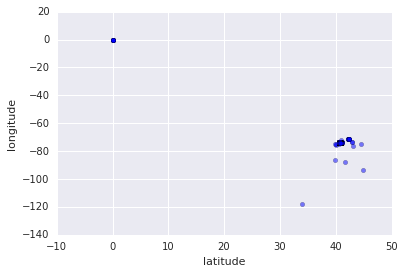

In [514]:
plt.scatter(train['latitude'], train['longitude'], alpha = 0.5)
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()

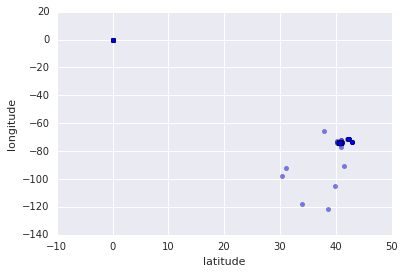

In [515]:
plt.scatter(test['latitude'], test['longitude'], alpha = 0.5)
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()

The geographic distribution of the training dataset and testing dataset are quite similar: a majority of dataset are located in 
New York city region while a small proportion of the datasets are scattered around, which I previously suspected them as outliers.

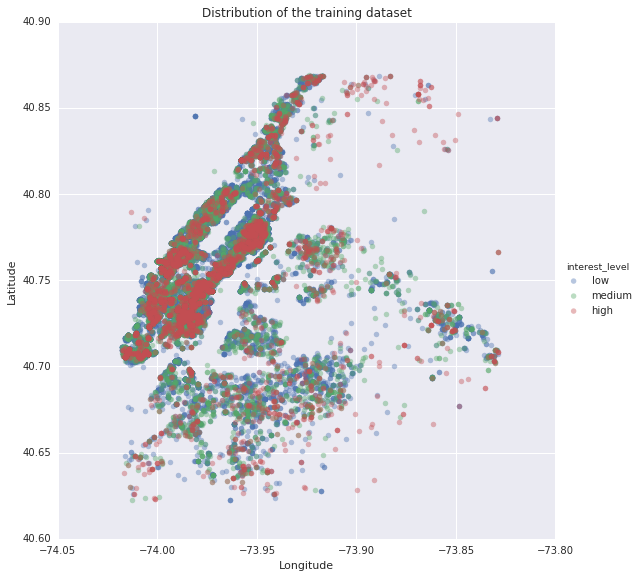

In [516]:
sns.lmplot(x = "longitude", y = "latitude", fit_reg = False, hue = 'interest_level',
           hue_order = ['low', 'medium', 'high'], size = 8, scatter_kws = {'alpha':0.4,'s':30},
           data = train[(train.longitude > train.longitude.quantile(0.005))
                           &(train.longitude < train.longitude.quantile(0.995))
                           &(train.latitude > train.latitude.quantile(0.005))                           
                           &(train.latitude < train.latitude.quantile(0.995))]);
plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.title('Distribution of the training dataset')

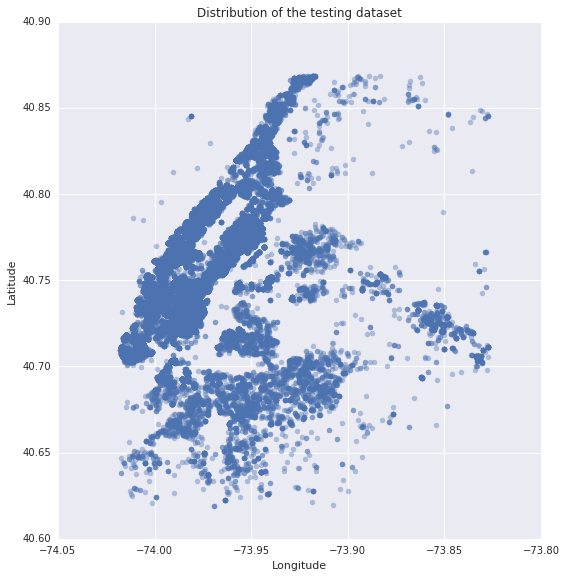

In [517]:
sns.lmplot(x = "longitude", y = "latitude", fit_reg = False, size = 8, scatter_kws = {'alpha':0.4,'s':30},
           data = test[(test.longitude > test.longitude.quantile(0.005))
                           &(test.longitude < test.longitude.quantile(0.995))
                           &(test.latitude > test.latitude.quantile(0.005))                           
                           &(test.latitude < test.latitude.quantile(0.995))]);
plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.title('Distribution of the testing dataset')

The geographical distribution of the training and testing dataset are visually very similar.

#### 6.price

C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


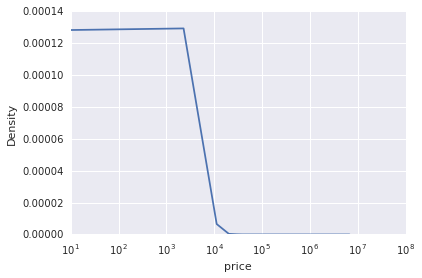

In [518]:
# Kernel Density Estimate plot
train['price'].plot(logx = True, logy = False, xlim = [10, 10e7], kind = 'kde')
plt.xlabel("price")
plt.show()

C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


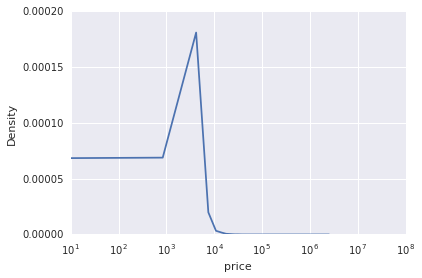

In [519]:
test['price'].plot(logx = True, logy = False, xlim = [10, 10e7], kind = 'kde')
plt.xlabel("price")
plt.show()

The training dataset has more entries with price between 1000 and 10000.

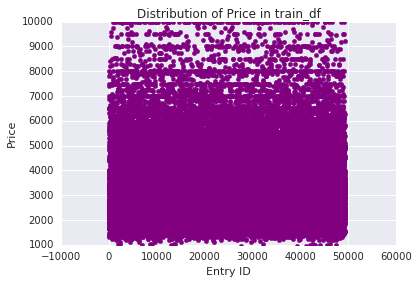

In [520]:
plt.scatter(range(train.shape[0]), train['price'].values, color = 'purple')
plt.ylim(1000, 10000)
plt.title("Distribution of Price in train_df")
plt.xlabel("Entry ID")
plt.ylabel("Price")

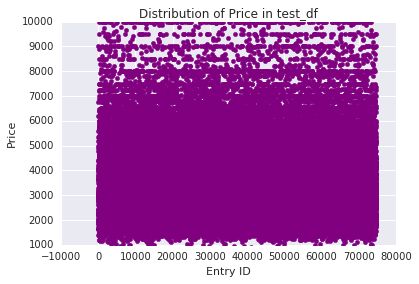

In [521]:
plt.scatter(range(test.shape[0]), test['price'].values, color = 'purple')
plt.ylim(1000, 10000)
plt.title("Distribution of Price in test_df")
plt.xlabel("Entry ID")
plt.ylabel("Price")

It's hard to tell any difference between the above two scattering plots.

#### 7.bedrooms & bathrooms 

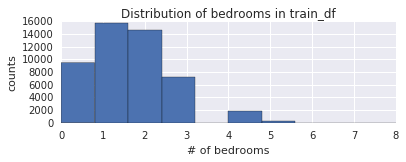

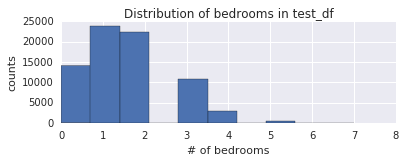

In [522]:
plt.subplot(2, 1, 1)
plt.hist(train['bedrooms'])
plt.title("Distribution of bedrooms in train_df")
plt.xlabel('# of bedrooms')
plt.ylabel('counts')
plt.show()

plt.subplot(2, 1, 2)
plt.hist(test['bedrooms'])
plt.title("Distribution of bedrooms in test_df")
plt.xlabel('# of bedrooms')
plt.ylabel('counts')
plt.show()

The distribution of bedrooms in the training dataset and testing dataset are similar.

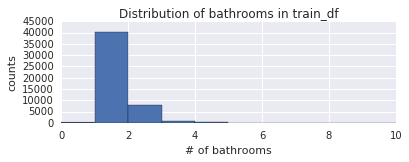

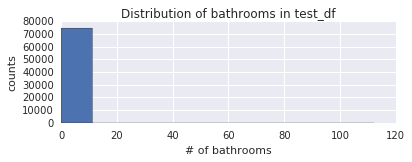

In [523]:
plt.subplot(2, 1, 1)
plt.hist(train['bathrooms'])
plt.title("Distribution of bathrooms in train_df")
plt.xlabel('# of bathrooms')
plt.ylabel('counts')
plt.show()

plt.subplot(2, 1, 2)
plt.hist(test['bathrooms'])
plt.title("Distribution of bathrooms in test_df")
plt.xlabel('# of bathrooms')
plt.ylabel('counts')
plt.show()

The distribution of bathrooms in the testing dataset is much bigger than that in the training dataset, with a maximum value of 120. It's hard to tell whether 120 bathroom is an outlier or real without looking deep into the building. Even if they are outliers, what values can we sustitute it for? Alternatively, if it is just one or two outliers, we can ignore them for now given that it won't influence the prediction result much.

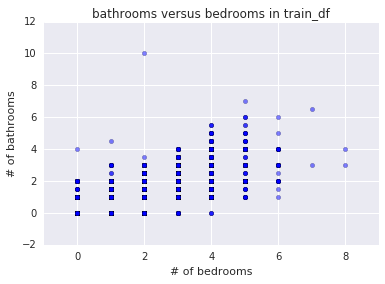

In [524]:
# scatter plot
plt.scatter(train['bedrooms'], train['bathrooms'], alpha = 0.5)
plt.title("bathrooms versus bedrooms in train_df")
plt.xlabel('# of bedrooms')
plt.ylabel('# of bathrooms')
plt.show()

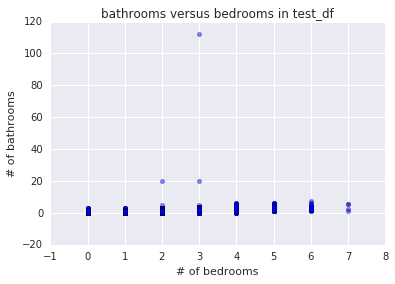

In [525]:
plt.scatter(test['bedrooms'], test['bathrooms'], alpha = 0.5)
plt.title("bathrooms versus bedrooms in test_df")
plt.xlabel('# of bedrooms')
plt.ylabel('# of bathrooms')
plt.show()

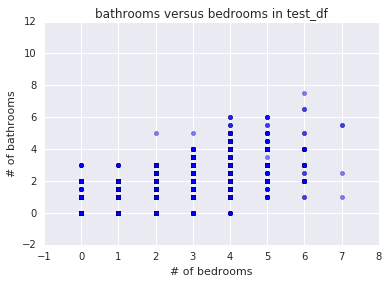

In [526]:
plt.scatter(test['bedrooms'], test['bathrooms'], alpha = 0.5)
plt.title("bathrooms versus bedrooms in test_df")
plt.xlabel('# of bedrooms')
plt.ylabel('# of bathrooms')
plt.ylim([-2, 12])
plt.show()

In both the training dataset and testing dataset, the number of bathrooms can be lower, equal to or higher than the number of bedrooms.

#### 8.features

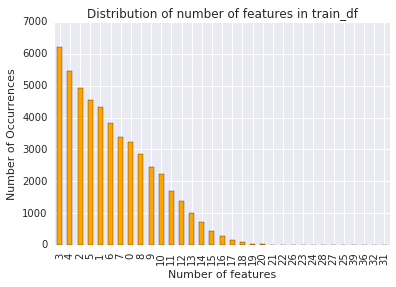

In [527]:
train['num_features'] = train['features'].apply(len)
train['num_features'].value_counts().plot(kind = 'bar',color = 'orange')
plt.title('Distribution of number of features in train_df')
plt.xlabel("Number of features")
plt.ylabel("Number of Occurrences")

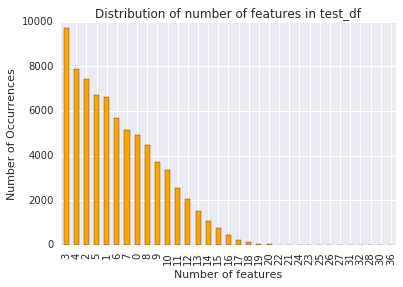

In [528]:
test['num_features'] = test['features'].apply(len)
test['num_features'].value_counts().plot(kind = 'bar',color = 'orange')
plt.title('Distribution of number of features in test_df')
plt.xlabel("Number of features")
plt.ylabel("Number of Occurrences")

Let's first extract important features from the training dataset.

In [529]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import itertools

vectorizer = CountVectorizer(min_df=1)
x = vectorizer.fit_transform(itertools.chain.from_iterable(train['features']))

names = vectorizer.get_feature_names()
counts = np.sum(x.toarray(), axis=0)
n2c = list(zip(names, counts))
n2c.sort(key=lambda x: x[1], reverse=True)
print(n2c[:30])

[('allowed', 45670), ('laundry', 29759), ('in', 29742), ('elevator', 26283), ('hardwood', 24628), ('floors', 23571), ('cats', 23553), ('dogs', 22043), ('doorman', 21169), ('dishwasher', 20828), ('building', 19338), ('fee', 18842), ('no', 18201), ('fitness', 13403), ('center', 13298), ('unit', 9865), ('war', 9203), ('pre', 9157), ('space', 7640), ('outdoor', 7269), ('deck', 7095), ('roof', 7058), ('room', 6214), ('dining', 5156), ('high', 5141), ('internet', 4324), ('speed', 4322), ('balcony', 3129), ('pool', 3126), ('swimming', 2738)]


Let's print out some high frequency terms in the training dataset: ('laundry', 29648), ('elevator', 26134), ('hardwood', 24575), 
('cats', 23471), ('dogs', 21968), ('doorman', 21061), ('dishwasher', 20775), ('fitness', 13311).

In [530]:
# Extract key features from the testing dataset.
vectorizer = CountVectorizer(min_df=1)
x = vectorizer.fit_transform(itertools.chain.from_iterable(test['features']))

names = vectorizer.get_feature_names()
counts = np.sum(x.toarray(), axis=0)
n2c = list(zip(names, counts))
n2c.sort(key=lambda x: x[1], reverse=True)
print(n2c[:30])

[('allowed', 68959), ('laundry', 44941), ('in', 44883), ('elevator', 39567), ('hardwood', 37257), ('cats', 35670), ('floors', 35621), ('dogs', 33182), ('doorman', 31876), ('dishwasher', 31280), ('building', 29173), ('fee', 28555), ('no', 27532), ('fitness', 20414), ('center', 20237), ('unit', 14874), ('war', 14054), ('pre', 13975), ('space', 11818), ('outdoor', 11280), ('deck', 10748), ('roof', 10694), ('room', 9242), ('dining', 7713), ('high', 7593), ('internet', 6361), ('speed', 6359), ('pool', 4999), ('balcony', 4819), ('swimming', 4429)]


Similarily, the high frequency terms in the testing dataset are ('laundry', 44941), ('elevator', 39567), ('hardwood', 37257), ('cats', 35670), ('dogs', 33182), ('doorman', 31876), ('dishwasher', 31280), ('fitness', 20414).

The training and testing dataset share the same high frequency terms in 'feature'.

#### 9.created 

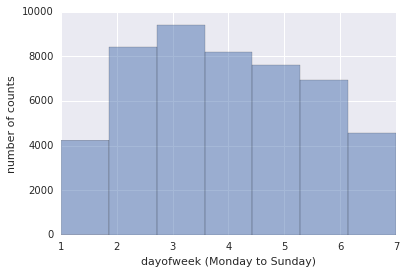

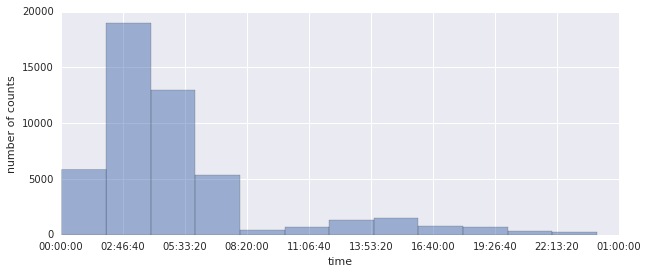

In [531]:
from datetime import time
from datetime import timezone
import datetime

times = pd.to_datetime(train['created']) # object to datetime64[ns]

train['dayofweek'] = [t.isoweekday() for t in times]
train['timeofday'] = [t.time() for t in times]

train['dayofweek'].hist(bins = 7, figsize = (6, 4), alpha = 0.5)
plt.xlabel('dayofweek (Monday to Sunday)')
plt.ylabel('number of counts')
plt.show()

train['timeofday'].hist(bins = 12, figsize = (10, 4), alpha = 0.5) # 1-8 am most
plt.ylabel('number of counts')
plt.show()

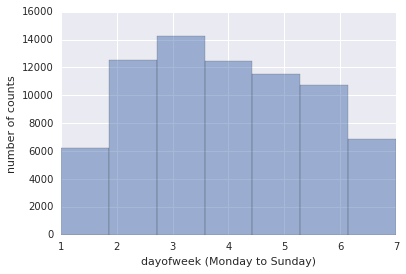

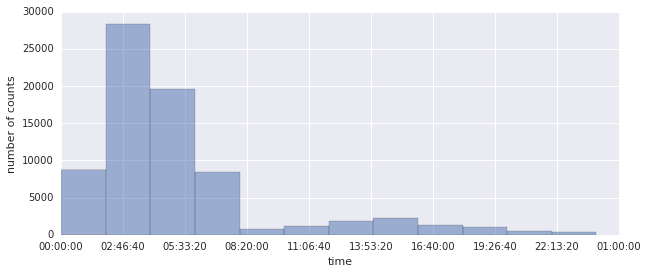

In [532]:
times = pd.to_datetime(test['created']) # object to datetime64[ns]

test['dayofweek'] = [t.isoweekday() for t in times]
test['timeofday'] = [t.time() for t in times]

test['dayofweek'].hist(bins = 7, figsize = (6, 4), alpha = 0.5)
plt.xlabel('dayofweek (Monday to Sunday)')
plt.ylabel('number of counts')
plt.show()

test['timeofday'].hist(bins = 12, figsize = (10, 4), alpha = 0.5) # 1-8 am most
plt.ylabel('number of counts')
plt.show()

For both the training and testing dataset, Monday and Sunday have slightly smaller amount of postings compared to the rest of the week while Wed has the maximum number of posts. Two peak posting times are roughly around 3:00:00 and 14:00:00 for both the training and testing dataset.

#### 10.photo

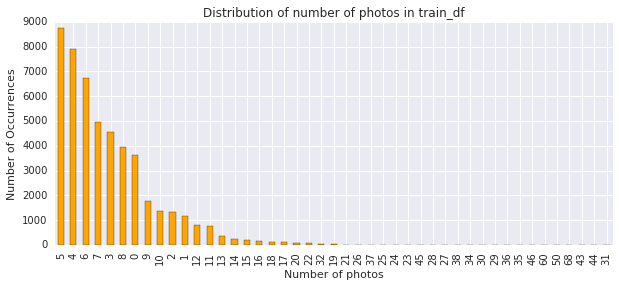

In [533]:
train['num_photos'] = train['photos'].apply(len)
train['num_photos'].value_counts().plot(kind = 'bar',color = 'orange', figsize = (10, 4))
plt.title('Distribution of number of photos in train_df')
plt.xlabel("Number of photos")
plt.ylabel("Number of Occurrences")

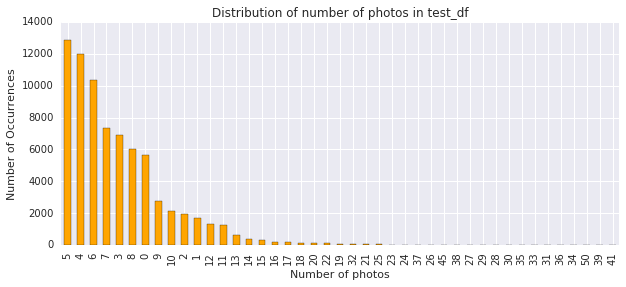

In [534]:
test['num_photos'] = test['photos'].apply(len)
test['num_photos'].value_counts().plot(kind = 'bar',color = 'orange', figsize = (10, 4))
plt.title('Distribution of number of photos in test_df')
plt.xlabel("Number of photos")
plt.ylabel("Number of Occurrences")

The training and testing dataset have similar distribution of number of photos in each posting.

#### 11.decription 

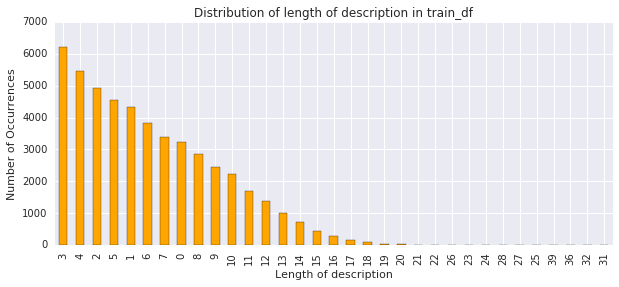

In [535]:
train['length_description'] = train['description'].apply(len)
train.num_features.value_counts().plot(kind='bar',color='orange', figsize = (10, 4))
plt.title('Distribution of length of description in train_df')
plt.xlabel("Length of description")
plt.ylabel("Number of Occurrences")

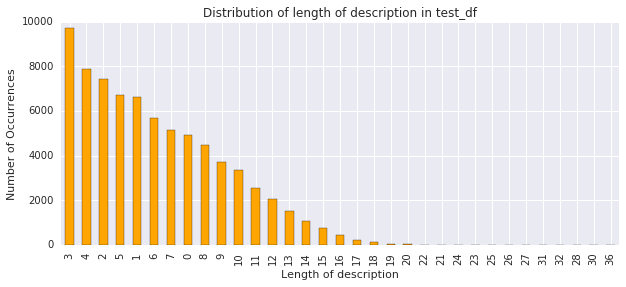

In [536]:
test['length_description'] = test['description'].apply(len)
test.num_features.value_counts().plot(kind='bar', color='orange', figsize = (10, 4))
plt.title('Distribution of length of description in test_df')
plt.xlabel("Length of description")
plt.ylabel("Number of Occurrences")

The training and testing dataset have similar distribution of length of description in each posting.

#### 12.Display Address

Display_address that appear less than 2 times: 63.22%
Display_address that appear less than 10 times: 89.6%
Display_address that appear less than 50 times: 97.73%
Display_address that appear less than 100 times: 99.26%
Display_address that appear less than 500 times: 100.0%


C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


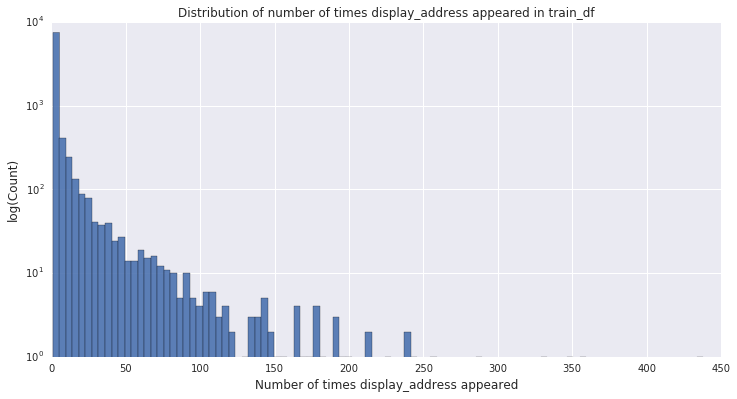

In [537]:
cnt_add = train.groupby('display_address')['display_address'].count()

for i in [2, 10, 50, 100, 500]:
    print('Display_address that appear less than {} times: {}%'.format(i, round((cnt_add < i).mean() * 100, 2)))

plt.figure(figsize=(12, 6))
plt.hist(cnt_add.values, bins = 100, log = True, alpha = 0.9)
plt.title('Distribution of number of times display_address appeared in train_df')
plt.xlabel('Number of times display_address appeared', fontsize=12)
plt.ylabel('log(Count)', fontsize=12)
plt.show()

Display_address that appear less than 2 times: 63.9%
Display_address that appear less than 10 times: 89.48%
Display_address that appear less than 50 times: 97.25%
Display_address that appear less than 100 times: 98.83%
Display_address that appear less than 500 times: 99.97%


C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


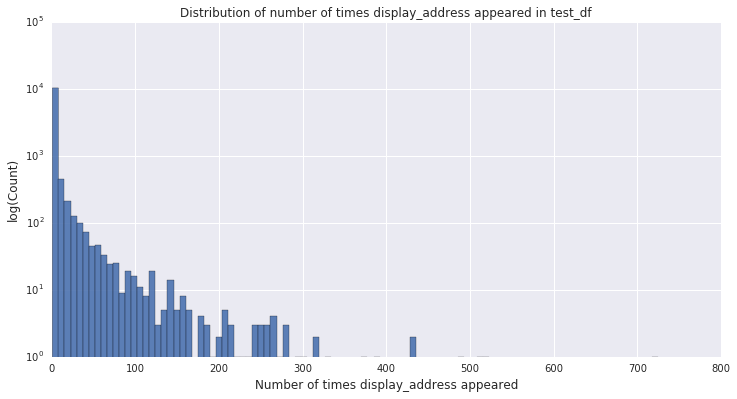

In [538]:
cnt_add = test.groupby('display_address')['display_address'].count()

for i in [2, 10, 50, 100, 500]:
    print('Display_address that appear less than {} times: {}%'.format(i, round((cnt_add < i).mean() * 100, 2)))

plt.figure(figsize=(12, 6))
plt.hist(cnt_add.values, bins = 100, log = True, alpha = 0.9)
plt.title('Distribution of number of times display_address appeared in test_df')
plt.xlabel('Number of times display_address appeared', fontsize=12)
plt.ylabel('log(Count)', fontsize=12)
plt.show()

### Notes:
Other plottings with various features against interest_level were tried and embeded into feature engineering, but significant
degrade in prediction accuracy were found. Thus all such efforts are not shown above. Refer to file titled 'NYC_Rental_Full_Statistical_Analysis' for more details.

### Part II. Feature Engineering
Do the following feature engineering to both the train and the test dataset.
- Naive feature engineering to get sum, average and counts of some features
- Extract key words from features and map these key words into binary values (0, 1)
- Special designation for building_ids, manager_ids, display_address with only 1 observation, change into -1
- High-Cardinality Categorical encoding
- Factorize building_id, display_address, manager_id, street_address

#### 1.Define Functions

In [539]:
def add_features(df):
    """
    naive feature engineering
    """
    fmt = lambda s: s.replace("\u00a0", "").strip().lower()
    df["num_photos"] = df["photos"].apply(len)
    
    df["street_address"] = df['street_address'].apply(fmt)
    df["display_address"] = df["display_address"].apply(fmt)
    df["desc_wordcount"] = df["description"].apply(str.split).apply(len)
    
    df["pricePerBed"] = df['price'] / df['bedrooms']
    df["pricePerBath"] = df['price'] / df['bathrooms']
    df["pricePerRoom"] = df['price'] / (df['bedrooms'] + df['bathrooms'])
    
    df["bedPerBath"] = df['bedrooms'] / df['bathrooms']
    df["bedBathDiff"] = df['bedrooms'] - df['bathrooms']
    df["bedBathSum"] = df["bedrooms"] + df['bathrooms']
    df["bedsPerc"] = df["bedrooms"] / (df['bedrooms'] + df['bathrooms'])
    
    # fill NAN values with -1 and replace infinity value with -1
    df = df.fillna(-1).replace(np.inf, -1)
    return df

In [540]:
def factorize(df1, df2, column):
    """
    Encode input values as a categorical variable (i.e., 0, 1, 2,…..)
    Return the unique values. Index is returned when passed values is Index or Series
    """
    ps = df1[column].append(df2[column])
    # Encode input values as an enumerated type (0, 1, 2, ...), return labels
    factors = ps.factorize()[0]
    df1[column] = factors[:len(df1)]
    df2[column] = factors[len(df1):]
    return df1, df2

In [541]:
def designate_single_observations(df1, df2, column):
    """
    designate single observations in column into -1
    """
    ps = df1[column].append(df2[column])
    grouped = ps.groupby(ps).size().to_frame().rename(columns = {0: "size"})
    df1.loc[df1.join(grouped, on = column, how = "left")["size"] <= 1, column] = -1
    df2.loc[df2.join(grouped, on = column, how = "left")["size"] <= 1, column] = -1
    return df1, df2

In [542]:
def hcc_encode(train_df, test_df, variable, target, prior_prob, k, f = 1, g = 1, r_k = None, update_df = None):
    """
    High-Cardinality Categorical encoding
    """
    hcc_name = "_".join(["hcc", variable, target])

    grouped = train_df.groupby(variable)[target].agg({"size": "size", "mean": "mean"})
    grouped["lambda"] = 1 / (g + np.exp((k - grouped["size"]) / f))
    grouped[hcc_name] = grouped["lambda"] * grouped["mean"] + (1 - grouped["lambda"]) * prior_prob

    df = test_df[[variable]].join(grouped, on = variable, how = "left")[hcc_name].fillna(prior_prob)
    if r_k: df *= np.random.uniform(1 - r_k, 1 + r_k, len(test_df))     # Add uniform noise. Not mentioned in original paper

    if update_df is None: update_df = test_df
    if hcc_name not in update_df.columns: update_df[hcc_name] = np.nan
    update_df.update(df)
    return

In [543]:
def create_binary_features(df):
    """
    Extract key words from features and create binary columns including features in bows, with values either 0 or 1
    """
    bows = {
        "dogs": ("dogs", "dog"),
        "cats": ("cats",),
        "nofee": ("no fee", "no-fee", "no  fee", "nofee", "no_fee"),
        "lowfee": ("reduced_fee", "low_fee", "reduced fee", "low fee"),
        "furnished": ("furnished",),
        "parquet": ("parquet", "hardwood"),
        "concierge": ("concierge", "doorman", "housekeep", "in_super"),
        "prewar": ("prewar", "pre_war", "pre war", "pre-war"),
        "laundry": ("laundry", "lndry"),
        "health": ("health", "gym", "fitness", "training"),
        "transport": ("train", "subway", "transport"),
        "parking": ("parking",),
        "utilities": ("utilities", "heat water", "water included")
    }
    
    def indicator(bow):
        return lambda s: int(any([x in s for x in bow]))

    features = df["features"].apply(lambda f: " ".join(f).lower())
    for key in bows:
        df["feature_" + key] = features.apply(indicator(bows[key]))

    return df

In [544]:
# reload the data in case I did modified the train and test data in statistical analysis
train = pd.read_json('train.json')
test = pd.read_json('test.json')

In [545]:
# Map interest level into 0, 1, 2
train = train.replace({"interest_level": {"low": 0, "medium": 1, "high": 2}})
# convert interest_level into dummy variables
train = train.join(pd.get_dummies(train["interest_level"], prefix = "pred").astype(int))
prior_0, prior_1, prior_2 = train[["pred_0", "pred_1", "pred_2"]].mean()

#### 2.Feature Engineering

In [546]:
# Add naively engineered features such as num_photos, price per bedroom/bathroom/room etc
train = add_features(train)
test = add_features(test)

In [547]:
# Special designation for building_ids, manager_ids, display_address with only 1 observation, change into -1
for col in ('building_id', 'manager_id', 'display_address'):
    train, test = designate_single_observations(train, test, col)

In [548]:
# High-Cardinality Categorical encoding
skf = StratifiedKFold(5)
attributes = product(("building_id", "manager_id"), zip(("pred_1", "pred_2"), (prior_1, prior_2)))
for variable, (target, prior) in attributes:
    hcc_encode(train, test, variable, target, prior, k=5, r_k=None)
    for tr, te in skf.split(np.zeros(len(train)), train['interest_level']):
        hcc_encode(train.iloc[tr], train.iloc[te], variable, target, prior, k=5, r_k=0.01, update_df = train)

In [549]:
# Factorize building_id, display_address, manager_id, street_address
for col in ('building_id', 'display_address', 'manager_id', 'street_address'):
    # encode col into numerical values starting from 0, 1, 2,....
    train, test = factorize(train, test, col)

In [550]:
# Create binarized features
train = create_binary_features(train)
test = create_binary_features(test)

Drop unnecessary features (which are transformed to other features or won't be used)

In [551]:
train = train.drop(["photos", "pred_0","pred_1", "pred_2", "description","building_id", "features", "created"], axis = 1)
test = test.drop(["photos", "description","building_id", "features", "created"], axis = 1)

In [552]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 36 columns):
bathrooms                 49352 non-null float64
bedrooms                  49352 non-null int64
display_address           49352 non-null int64
interest_level            49352 non-null int64
latitude                  49352 non-null float64
listing_id                49352 non-null int64
longitude                 49352 non-null float64
manager_id                49352 non-null int64
price                     49352 non-null int64
street_address            49352 non-null int64
num_photos                49352 non-null int64
desc_wordcount            49352 non-null int64
pricePerBed               49352 non-null float64
pricePerBath              49352 non-null float64
pricePerRoom              49352 non-null float64
bedPerBath                49352 non-null float64
bedBathDiff               49352 non-null float64
bedBathSum                49352 non-null float64
bedsPerc                  

In [578]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 99999
Data columns (total 35 columns):
bathrooms                 74659 non-null float64
bedrooms                  74659 non-null int64
display_address           74659 non-null int64
latitude                  74659 non-null float64
listing_id                74659 non-null int64
longitude                 74659 non-null float64
manager_id                74659 non-null int64
price                     74659 non-null int64
street_address            74659 non-null int64
num_photos                74659 non-null int64
desc_wordcount            74659 non-null int64
pricePerBed               74659 non-null float64
pricePerBath              74659 non-null float64
pricePerRoom              74659 non-null float64
bedPerBath                74659 non-null float64
bedBathDiff               74659 non-null float64
bedBathSum                74659 non-null float64
bedsPerc                  74659 non-null float64
hcc_building_id_pred_1   

### Part III. Machine Learning
The metric used for evaluating the performance of the machine learning algorithms is log_loss. See the following link for details: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html.

The following machine learning algorithms are used:
- logistic regression
- random forests
- XGBoost
- LightGBM

#### Notes: Other commonly used supervised classification machine learning algorithms such as SVM, NB are also considered, but they perform really poor thus were not shown here.

In [554]:
# preserve listing_id for exporting result
sub = pd.DataFrame()
sub["listing_id"] = pd.read_json('test.json')["listing_id"]

#### 1. Logistic Regression

In [555]:
# import sklearn modules
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

Train_model

In [556]:
y = train['interest_level']
train = train.drop(['interest_level'], axis = 1)
x = train.values

In [557]:
validation_size = 0.30
seed = 2018
X_train, X_validation, Y_train, Y_validation = train_test_split(x, y, test_size = validation_size, random_state = seed)

clf = LogisticRegression(tol = 1e-8, fit_intercept = True, random_state = 5, max_iter = 100)
clf.fit(X_train, Y_train)
y_val_pred = clf.predict_proba(X_validation)
log_loss(Y_validation, y_val_pred)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.66897508610265777

The above error arises because np.float64 can't handle a number as large as used. Using np.float128 instead will probably solve the problem. Ignore it for now.

In [558]:
y_pred = clf.predict_proba(test)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [559]:
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
labels2idx = {'high': 2, 'low':0, 'medium':1}

In [561]:
for label in ["high", "medium", "low"]:
    sub[label] = y_pred[:, labels2idx[label]]
sub.to_csv("Demo_lr.csv", index = False)

log_loss score on Kaggle leadership board: 0.65791

#### 2. Random Forests

In [562]:
from sklearn.ensemble import RandomForestClassifier

Train data

In [563]:
clf = RandomForestClassifier(n_estimators = 1000)
clf.fit(X_train, Y_train)
y_val_pred = clf.predict_proba(X_validation)
log_loss(Y_validation, y_val_pred)

0.57510529315044279

Make predictions

In [564]:
y_pred = clf.predict_proba(test)

In [565]:
for label in ["high", "medium", "low"]:
    sub[label] = y_pred[:, labels2idx[label]]
sub.to_csv("Demo_rf.csv", index=False)

log_loss score on Kaggle leadership board: 0.58162

### XGBoost

In [575]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [577]:
model = XGBClassifier()

# scan model parameters and find the optimized model
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1]
max_depth = [5, 10, 15]
n_estimators = [10, 20, 50, 100, 150, 200]

param_grid = dict(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth)

#kfold = StratifiedKFold(Y_train, n_folds = 5, shuffle = True, random_state = 2018)
grid_search = GridSearchCV(model, param_grid, scoring = 'neg_log_loss', n_jobs = -1, cv = skf)
result = grid_search.fit(X_train, Y_train)

# summarize results
print("BestL %f using %s" % (- result.best_score_, result.best_params_))
means, stdevs = [], []
for params, mean_score, scores in result.grid_scores_:
    stdev = scores.std()
    means.append(- mean_score)
    stdevs.append(stdev)
    print("%f (%f) with: %r" %(- mean_score, stdev, params))    

BestL 0.549423 using {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2}
1.097943 (0.000004) with: {'max_depth': 5, 'n_estimators': 10, 'learning_rate': 0.0001}
1.097275 (0.000008) with: {'max_depth': 5, 'n_estimators': 20, 'learning_rate': 0.0001}
1.095277 (0.000020) with: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.0001}
1.091970 (0.000040) with: {'max_depth': 5, 'n_estimators': 100, 'learning_rate': 0.0001}
1.088692 (0.000059) with: {'max_depth': 5, 'n_estimators': 150, 'learning_rate': 0.0001}
1.085441 (0.000078) with: {'max_depth': 5, 'n_estimators': 200, 'learning_rate': 0.0001}
1.097902 (0.000007) with: {'n_estimators': 10, 'max_depth': 10, 'learning_rate': 0.0001}
1.097193 (0.000014) with: {'max_depth': 10, 'n_estimators': 20, 'learning_rate': 0.0001}
1.095073 (0.000036) with: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.0001}
1.091566 (0.000075) with: {'max_depth': 10, 'n_estimators': 100, 'learning_rate': 0.0001}
1.088089 (0.000115) with: {'max

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


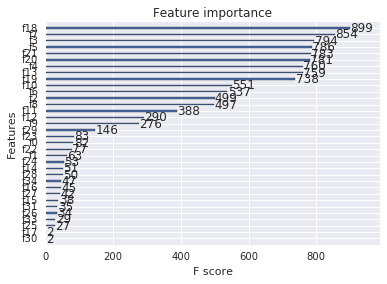

In [308]:
model = XGBClassifier(learning_rate = 0.2, n_estimators = 150, max_depth = 5)
model.fit(X_train, Y_train)
plot_importance(model)
plt.show()

In [310]:
y_pred = model.predict_proba(test.values)

In [311]:
for label in ["high", "medium", "low"]:
    sub[label] = y_pred[:, labels2idx[label]]
sub.to_csv("Demo_xgb.csv", index = False)

log_loss score on Kaggle leadership board: 0.55883

### LightGBM
Code partially adapted from https://www.kaggle.com/somnisight/microsoft-lightgbm-starter

Microsoft LightGBM is a powerful, open-source boosted decision tree library similar to xgboost. In practice, it runs even faster than xgboost and achieves better performance in some cases.

Let's start with define hyperparameters for LightGBM.

In [566]:
import lightgbm as lgbm

# parameters are mostly default, need to be tuned
t4_params = {
    'boosting_type': 'gbdt', 'objective': 'multiclass', 'nthread': -1, 'silent': True,
    'num_leaves': 2**4, 'learning_rate': 0.05, 'max_depth': -1,
    'max_bin': 255, 'subsample_for_bin': 50000,
    'subsample': 0.8, 'subsample_freq': 1, 'colsample_bytree': 0.6, 'reg_alpha': 1, 'reg_lambda': 0,
    'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 10, 'scale_pos_weight': 1}

Early Stopping with Cross Validation
Similar to xgboost, we can use cross validation with early stopping to efficiently determine the optimal "n_estimators" value.

In [567]:
lgbm_params = t4_params.copy()
lgbm_params['num_class'] = 3

# prepare data for lgbm
dset = lgbm.Dataset(x, y, silent = True)
   
# perform cross-validation
cv_results = lgbm.cv(lgbm_params, dset, num_boost_round = 10000, nfold = 5, stratified = False, shuffle = True, metrics = 'multi_logloss', 
                     early_stopping_rounds = 100, verbose_eval = 50, show_stdv = True, seed = 0)
    
print('best n_estimators:', len(cv_results['multi_logloss-mean']))
print('best cv score:', cv_results['multi_logloss-mean'][-1])

C:\Users\Administrator\Anaconda3\lib\site-packages\lightgbm\basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


[50]	cv_agg's multi_logloss: 0.627615 + 0.00266108
[100]	cv_agg's multi_logloss: 0.580429 + 0.00389281
[150]	cv_agg's multi_logloss: 0.565577 + 0.00435147
[200]	cv_agg's multi_logloss: 0.557866 + 0.0048216
[250]	cv_agg's multi_logloss: 0.552837 + 0.00520839
[300]	cv_agg's multi_logloss: 0.549559 + 0.0056167
[350]	cv_agg's multi_logloss: 0.547424 + 0.00584178
[400]	cv_agg's multi_logloss: 0.545727 + 0.00594726
[450]	cv_agg's multi_logloss: 0.544382 + 0.00606487
[500]	cv_agg's multi_logloss: 0.543305 + 0.00618968
[550]	cv_agg's multi_logloss: 0.542336 + 0.00613659
[600]	cv_agg's multi_logloss: 0.541576 + 0.0062279
[650]	cv_agg's multi_logloss: 0.541019 + 0.00628733
[700]	cv_agg's multi_logloss: 0.540383 + 0.00641479
[750]	cv_agg's multi_logloss: 0.539868 + 0.00652659
[800]	cv_agg's multi_logloss: 0.53955 + 0.00657551
[850]	cv_agg's multi_logloss: 0.539288 + 0.00677642
[900]	cv_agg's multi_logloss: 0.539072 + 0.00679453
[950]	cv_agg's multi_logloss: 0.538903 + 0.0068784
[1000]	cv_agg's mu

In [569]:
#model = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=1, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, **kwargs)
model = lgbm.sklearn.LGBMClassifier(n_estimators = 1258, seed = 2018, **t4_params)
model.fit(x, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
        learning_rate=0.05, max_bin=255, max_depth=-1,
        min_child_samples=10, min_child_weight=1, min_split_gain=0.5,
        n_estimators=1258, n_jobs=-1, nthread=-1, num_leaves=16,
        objective='multiclass', random_state=None, reg_alpha=1,
        reg_lambda=0, scale_pos_weight=1, seed=2018, silent=True,
        subsample=0.8, subsample_for_bin=50000, subsample_freq=1)

In [571]:
y_pred = model.predict_proba(test.values)

In [572]:
labels2idx = {'high': 2, 'low':0, 'medium':1}
for label in ["high", "medium", "low"]:
    sub[label] = y_pred[:, labels2idx[label]]
sub.to_csv("Demo_lgbm.csv", index = False)

log_loss score on Kaggle leadership board: 0.54110

### Conclusions

1, For all investigated algorithms here, LightGBM(0.54110)> XGBoost(0.55883) > Random Forests(0.58162) > Logistic Regression (0.65791). Naïve Bayes and SVM performs really bad. Maybe because naïve assumption doesn’t hold while SVM is good for “linear” separation which may not be the case here. 

2, Key engineered features are building_id, manager_id. listing_id is also important for getting small logloss value.

3, More feature engineering, single algorithm training and ensembing/stacking are needed to decrease the logloss and increase the prediction accuracy given enough time.

4, More investigation about the important features produced by XGBoost are needed in order to give some practical advice to those who are interested in the interest_levels of the apartment rental listings.
